# Initialize and load data / Khởi tạo và tải dữ liệu

We start by importing the necessary libraries and loading data from the `EV_Charging_Patterns.csv` file, which contains information about the charging behavior of electric vehicle users. / Chúng tôi bắt đầu bằng cách nhập các thư viện cần thiết và tải dữ liệu từ tệp `EV_Charging_Patterns.csv`, tệp này chứa thông tin về hành vi sạc của người dùng xe điện.


In [ ]:
import pandas as pd

# Load the dataset /  Tải tập dữ liệu
file_path = 'ev_charging_patterns.csv'
df = pd.read_csv(file_path)

# Inspect the structure of the dataset /  Kiểm tra cấu trúc của tập dữ liệu
print("First 5 rows of the dataset:")
print(df.head())

print("\nDataset information:")
print(df.info())

print("\nSummary statistics of the dataset:")
print(df.describe())

print("\nMissing values in the dataset:")
print(df.isnull().sum())

First 5 rows of the dataset:
  User ID Vehicle Model  Battery Capacity (kWh) Charging Station ID  \
0  User_1        BMW i3              108.463007         Station_391   
1  User_2  Hyundai Kona              100.000000         Station_428   
2  User_3    Chevy Bolt               75.000000         Station_181   
3  User_4  Hyundai Kona               50.000000         Station_327   
4  User_5  Hyundai Kona               50.000000         Station_108   

  Charging Station Location  Charging Start Time    Charging End Time  \
0                   Houston  2024-01-01 00:00:00  2024-01-01 00:39:00   
1             San Francisco  2024-01-01 01:00:00  2024-01-01 03:01:00   
2             San Francisco  2024-01-01 02:00:00  2024-01-01 04:48:00   
3                   Houston  2024-01-01 03:00:00  2024-01-01 06:42:00   
4               Los Angeles  2024-01-01 04:00:00  2024-01-01 05:46:00   

   Energy Consumed (kWh)  Charging Duration (hours)  Charging Rate (kW)  \
0              60.712346      

# Check Data Leakage / Kiểm tra rò rỉ dữ liệu


In [73]:
# Kiểm tra Leakage
leak_columns = ['User ID', 'Vehicle ID', 'Charging End Time']  # Các cột có thể gây leakage
cols_to_drop = [col for col in leak_columns if col in df.columns]

if cols_to_drop:
    df.drop(columns=cols_to_drop, inplace=True)
    print(f"✅ Đã loại bỏ các cột có nguy cơ leakage: {cols_to_drop}")
else:
    print("✅ Không phát hiện cột có nguy cơ leakage.")

✅ Đã loại bỏ các cột có nguy cơ leakage: ['User ID', 'Charging End Time']


# Exploratory Data Analysis (EDA) /  Phân tích dữ liệu thăm dò (EDA)
Perform basic EDA to understand the dataset, including checking for null values, data types, and summary statistics. / Thực hiện EDA cơ bản để hiểu tập dữ liệu, bao gồm kiểm tra giá trị null, kiểu dữ liệu và số liệu thống kê tóm tắt.


Unique values in each column:
User ID: 1320 unique values
Vehicle Model: 5 unique values
Battery Capacity (kWh): 147 unique values
Charging Station ID: 462 unique values
Charging Station Location: 5 unique values
Charging Start Time: 1320 unique values
Charging End Time: 1309 unique values
Energy Consumed (kWh): 1254 unique values
Charging Duration (hours): 1320 unique values
Charging Rate (kW): 1254 unique values
Charging Cost (USD): 1320 unique values
Time of Day: 4 unique values
Day of Week: 7 unique values
State of Charge (Start %): 1320 unique values
State of Charge (End %): 1320 unique values
Distance Driven (since last charge) (km): 1254 unique values
Temperature (°C): 1320 unique values
Vehicle Age (years): 114 unique values
Charger Type: 3 unique values
User Type: 3 unique values

Distribution of the target variable (User Type):
User Type
Commuter                  476
Long-Distance Traveler    437
Casual Driver             407
Name: count, dtype: int64


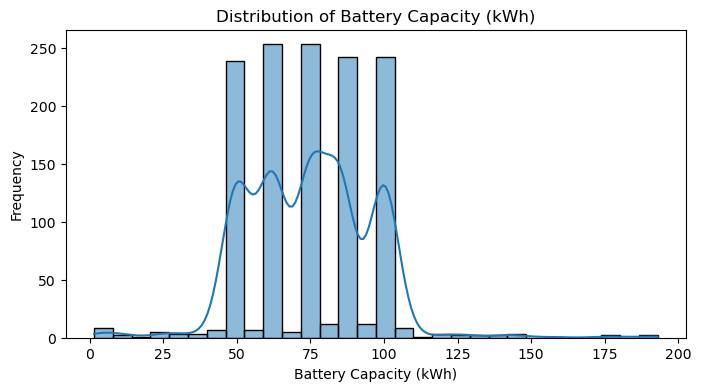

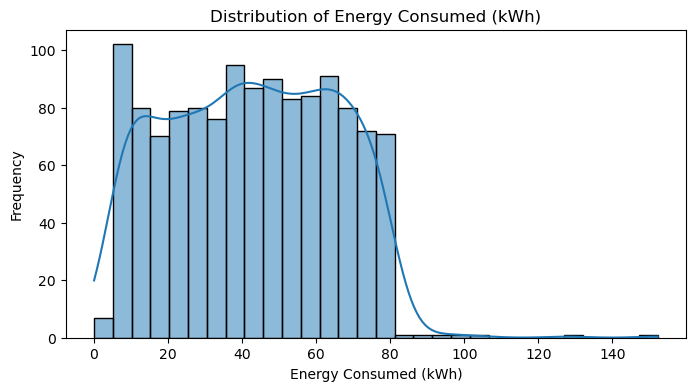

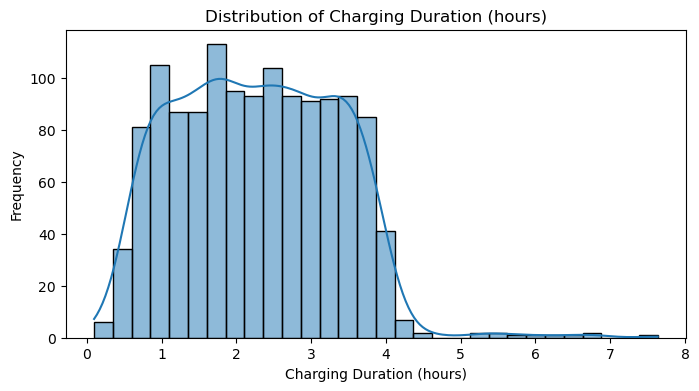

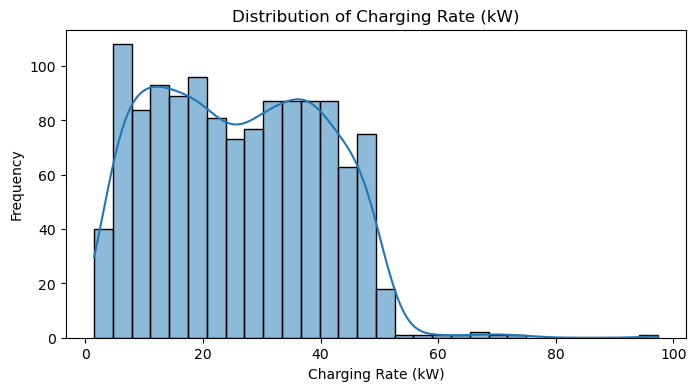

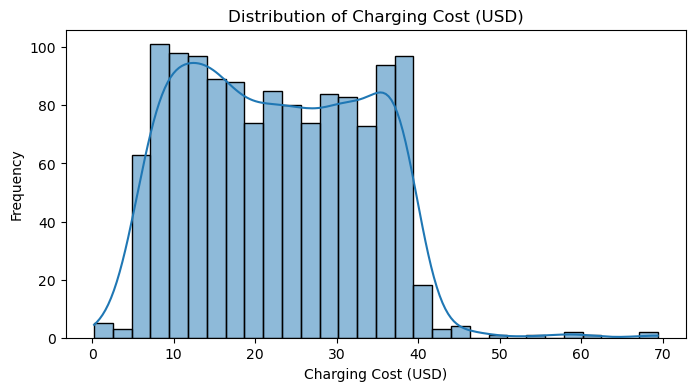

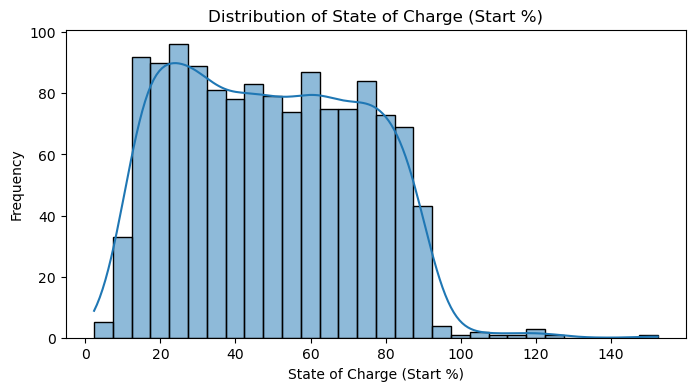

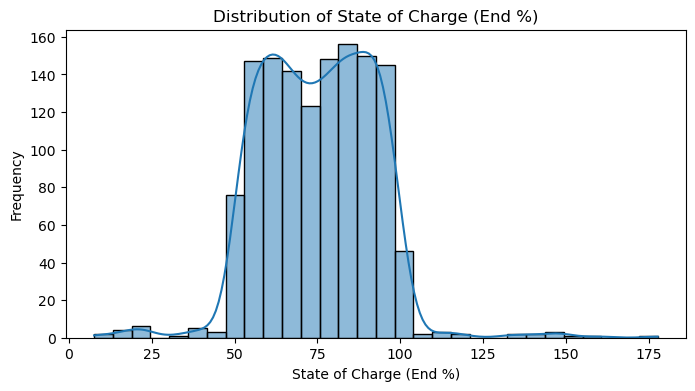

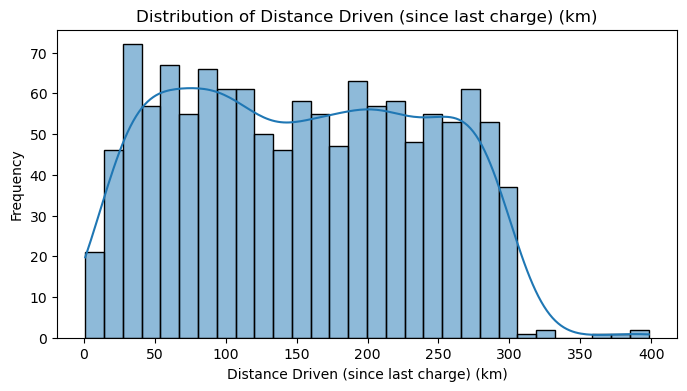

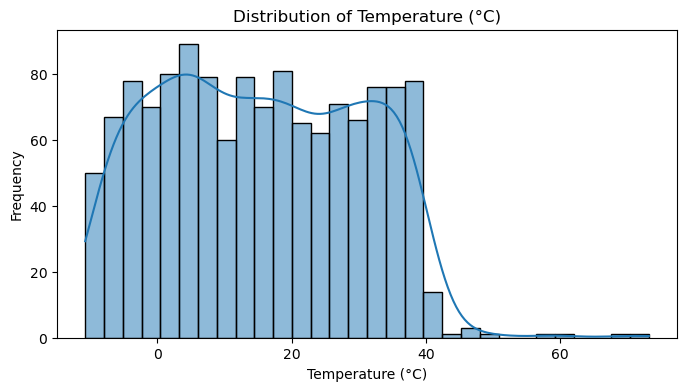

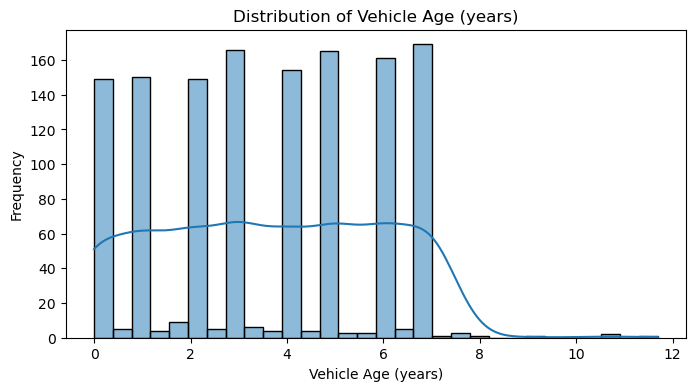

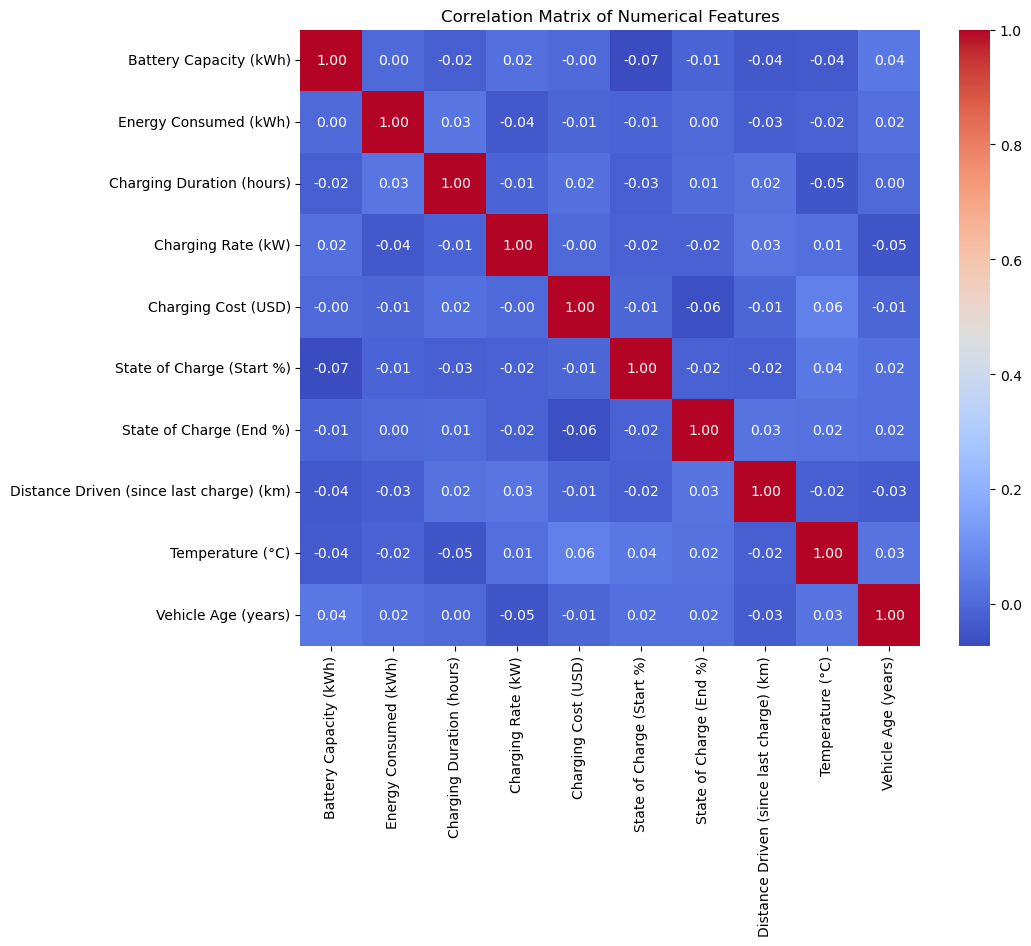

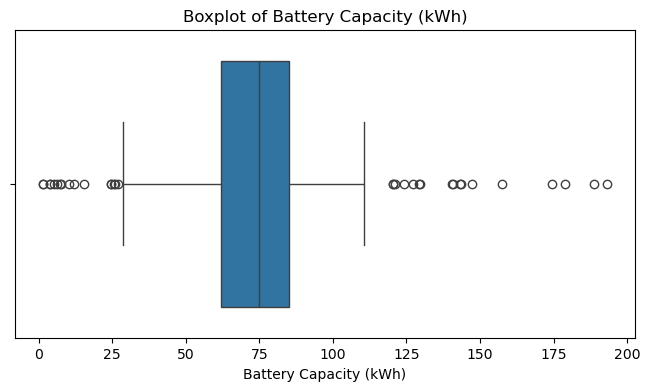

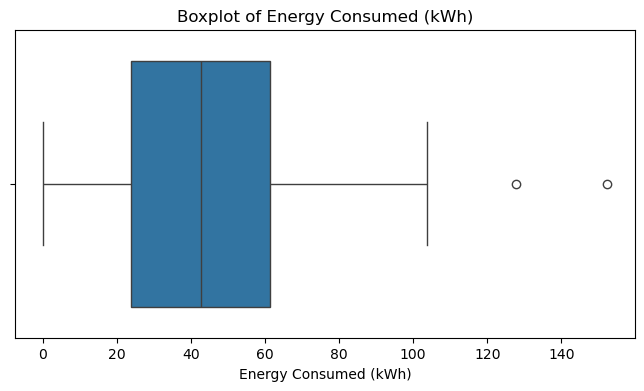

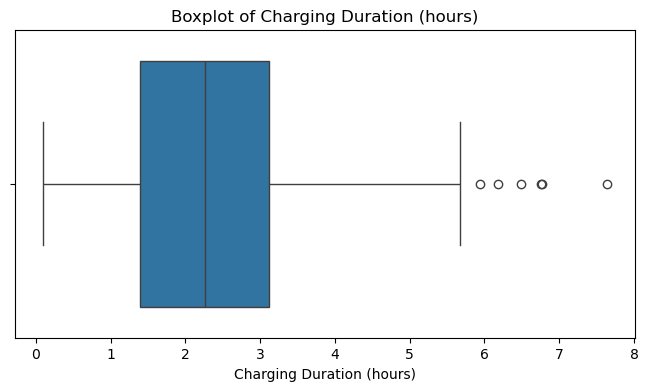

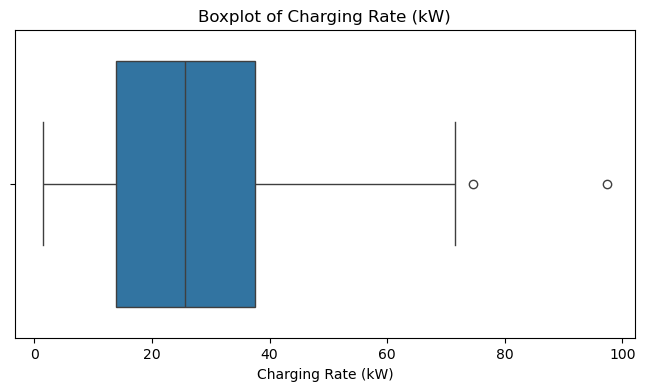

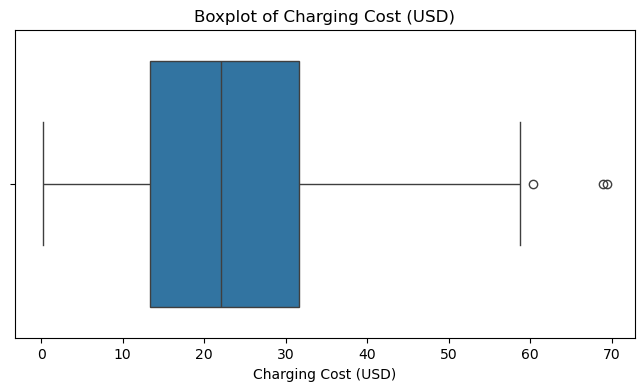

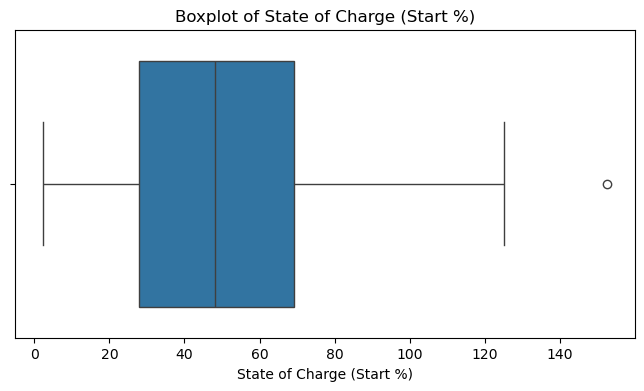

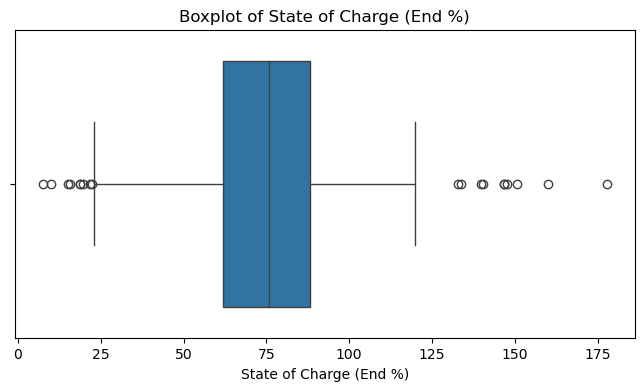

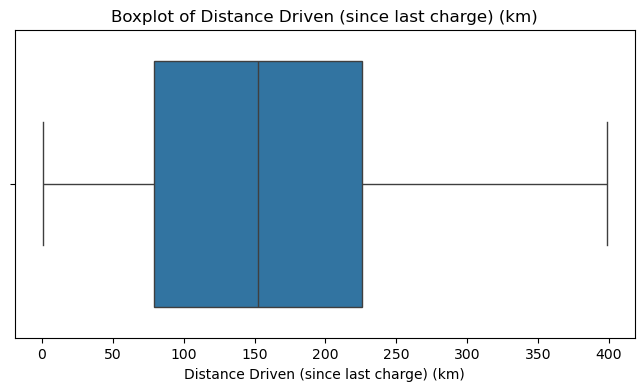

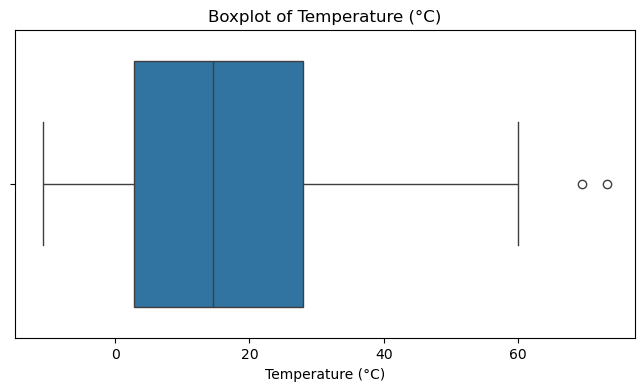

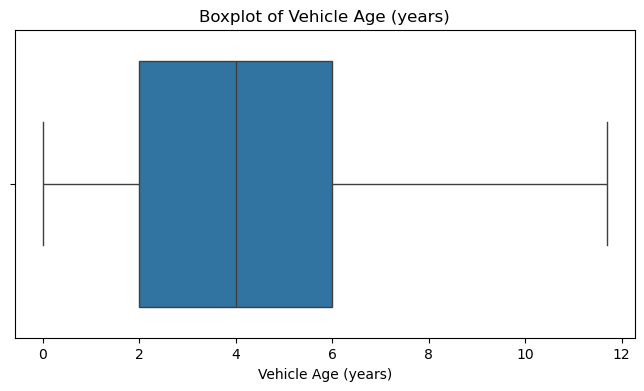

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = "ev_charging_patterns.csv"  # Update this path if necessary / Cập nhật đường dẫn này nếu cần thiết
df = pd.read_csv(file_path)

# Check for unique values in each column /  Kiểm tra các giá trị duy nhất trong mỗi cột
print("\nUnique values in each column:")
for column in df.columns:
    print(f"{column}: {df[column].nunique()} unique values")

# Check the distribution of the target variable /  Kiểm tra phân phối của biến mục tiêu
print("\nDistribution of the target variable (User Type):")
print(df['User Type'].value_counts())

# Visualize the distribution of numerical features / Hình dung sự phân bố của các đặc điểm số
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

for column in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

# Visualize correlations between numerical features / Hình dung mối tương quan giữa các tính năng số
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Check for outliers using boxplots / Kiểm tra các giá trị ngoại lai bằng cách sử dụng biểu đồ hộp
for column in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot of {column}")
    plt.xlabel(column)
    plt.show()

# Data Visualization / Trực quan hóa dữ liệu
Visualize data distributions, correlations, and class distributions using histograms, boxplots, heatmaps, and bar charts. / Trực quan hóa phân phối dữ liệu, tương quan và phân phối lớp bằng biểu đồ histogram, biểu đồ hộp, bản đồ nhiệt và biểu đồ thanh.

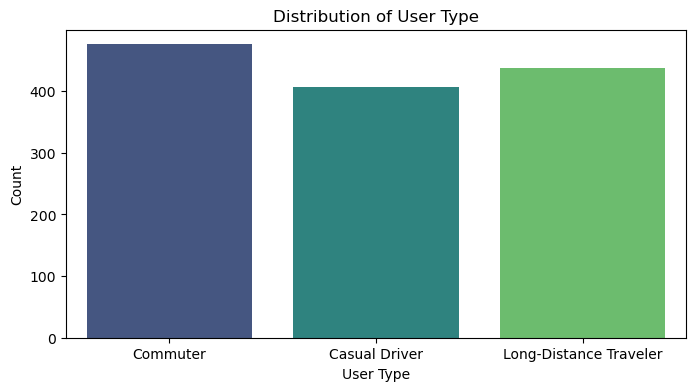

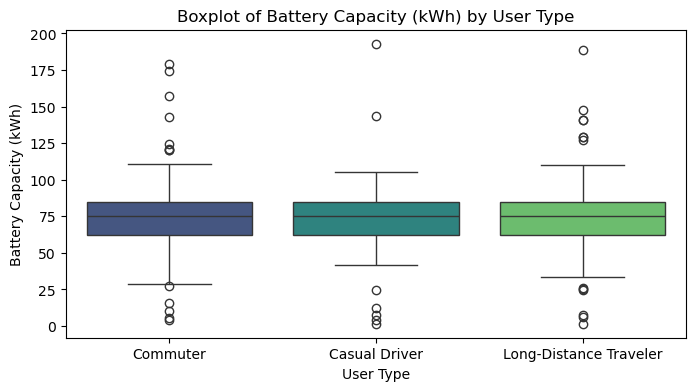

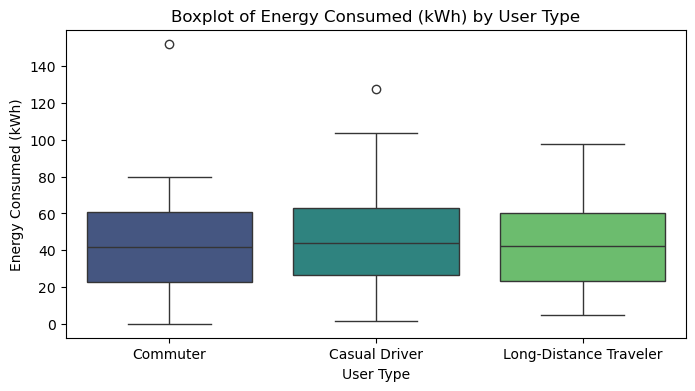

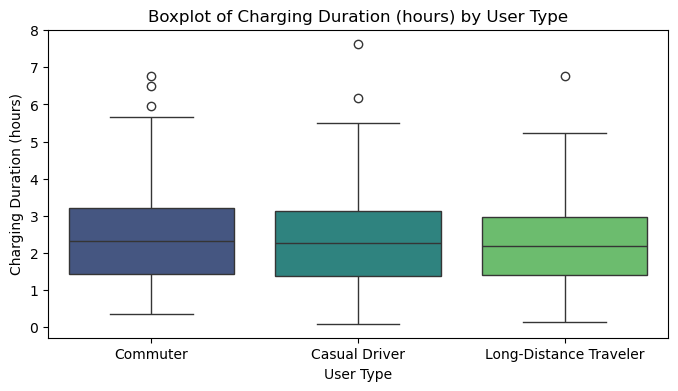

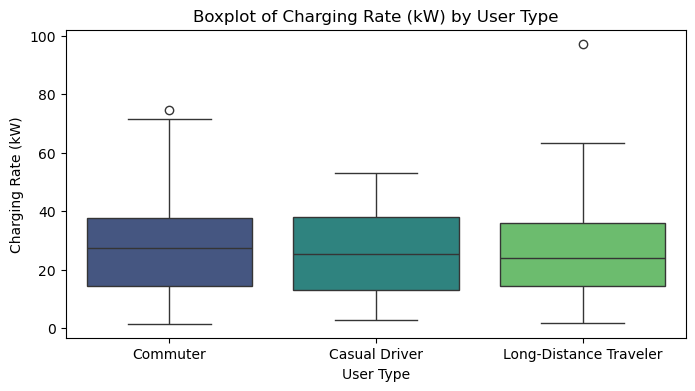

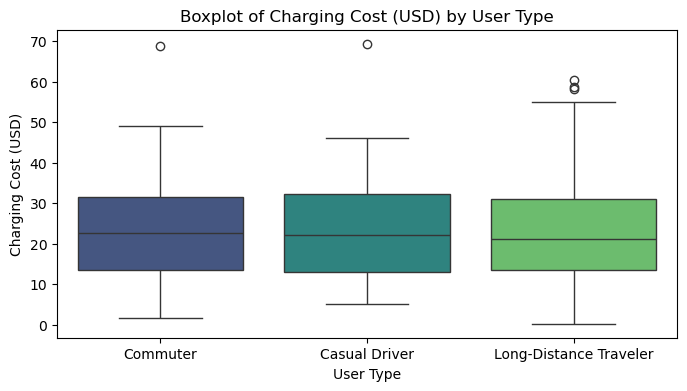

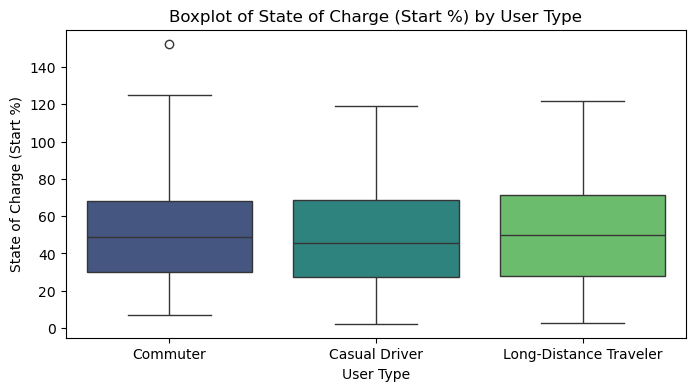

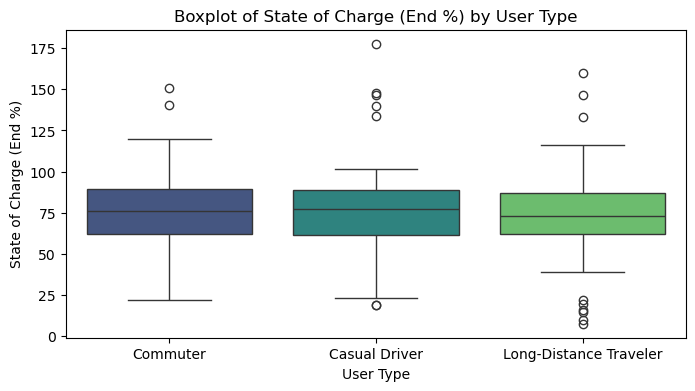

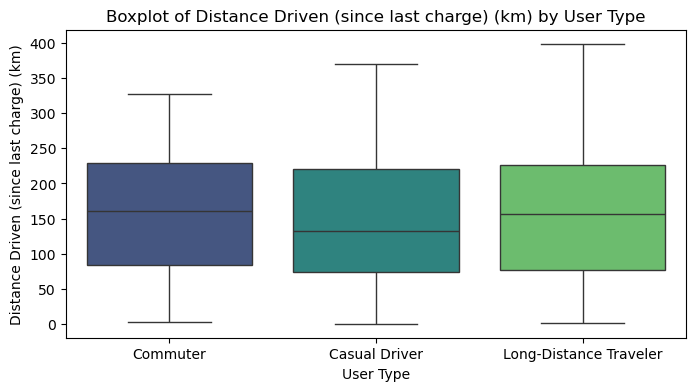

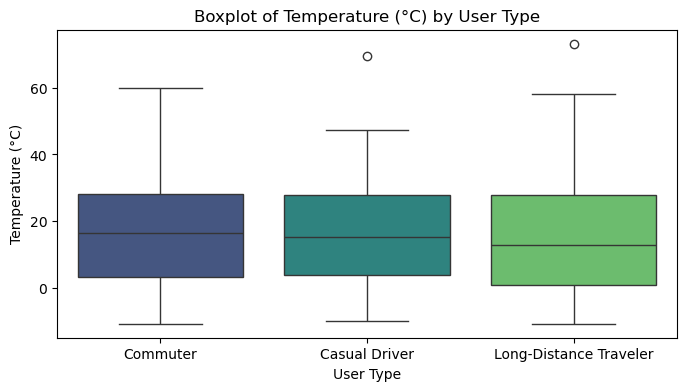

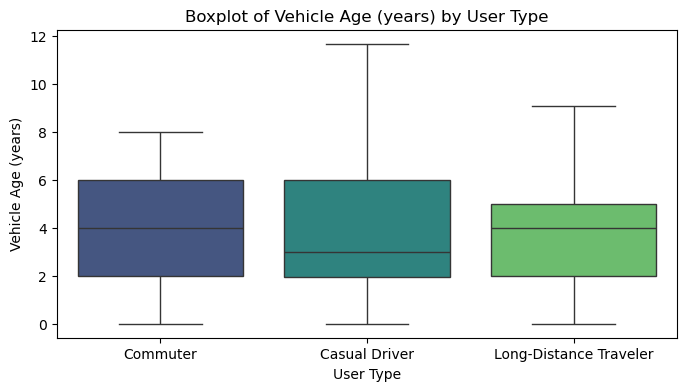

In [ ]:
# Visualize the distribution of the target variable (User Type) /  Hình dung sự phân phối của biến mục tiêu (Kiểu người dùng)
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='User Type', hue='User Type', palette='viridis', legend=False)
plt.title("Distribution of User Type")
plt.xlabel("User Type")
plt.ylabel("Count")
plt.show()

# Visualize the relationship between numerical features and the target variable /  Hình dung mối quan hệ giữa các đặc điểm số và biến mục tiêu
for column in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='User Type', y=column, hue='User Type', palette='viridis', legend=False)
    plt.title(f"Boxplot of {column} by User Type")
    plt.xlabel("User Type")
    plt.ylabel(column)
    plt.show()

# Visualize feature importance using SHAP values (placeholder for later integration) / Hình dung tầm quan trọng của tính năng bằng cách sử dụng giá trị SHAP (chỗ giữ chỗ để tích hợp sau).
# Note: SHAP values will be calculated after model training in a later section. / Lưu ý: Giá trị SHAP sẽ được tính toán sau khi đào tạo mô hình trong phần sau.


# Feature Engineering / Kỹ thuật tính năng
Create new features such as 'hour', 'day_of_week', 'is_weekend', and calculate the distance between charging sessions. / Tạo các tính năng mới như 'giờ', 'ngày_trong_tuần', 'là_cuối_tuần' và tính toán khoảng cách giữa các phiên sạc.

Columns in the dataset:
Index(['User ID', 'Vehicle Model', 'Battery Capacity (kWh)',
       'Charging Station ID', 'Charging Station Location',
       'Charging Start Time', 'Charging End Time', 'Energy Consumed (kWh)',
       'Charging Duration (hours)', 'Charging Rate (kW)',
       'Charging Cost (USD)', 'Time of Day', 'Day of Week',
       'State of Charge (Start %)', 'State of Charge (End %)',
       'Distance Driven (since last charge) (km)', 'Temperature (°C)',
       'Vehicle Age (years)', 'Charger Type', 'User Type'],
      dtype='object')

New features added to the dataset:
   hour  day_of_week  is_weekend Distance Between Charges
0     0            0           0                     None
1     1            0           0                     None
2     2            0           0                     None
3     3            0           0                     None
4     4            0           0                     None


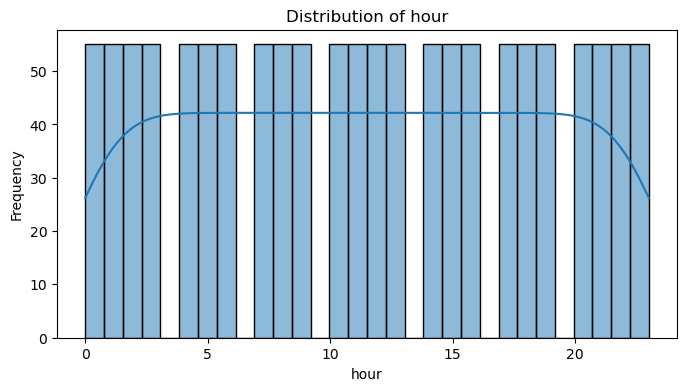

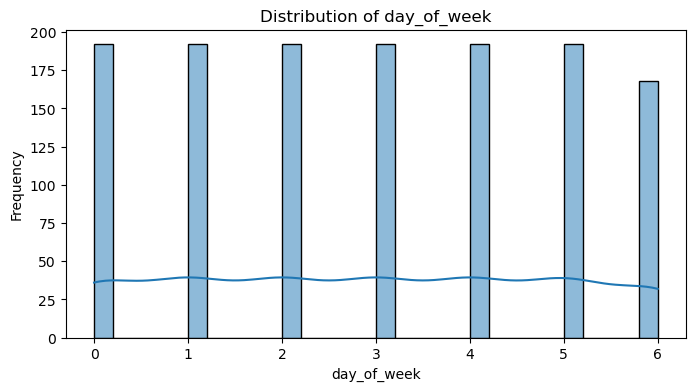

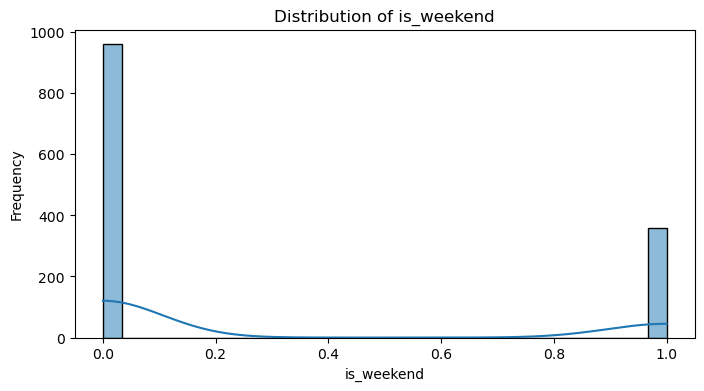

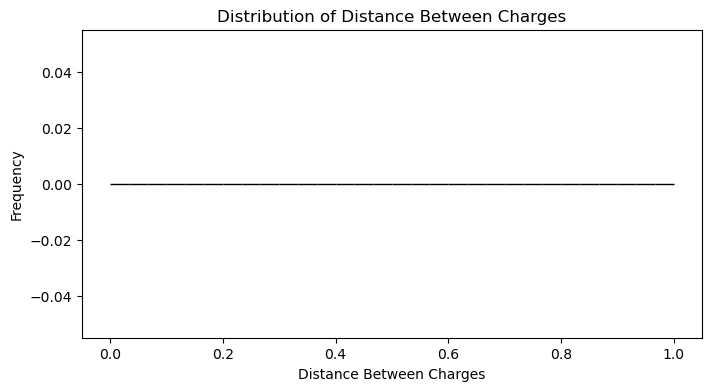

In [ ]:
# Inspect the dataset columns / Kiểm tra các cột tập dữ liệu
print("Columns in the dataset:")
print(df.columns)

# Extract hour, day_of_week, and is_weekend from 'Charging Start Time' / Trích xuất giờ, ngày_trong_tuần và is_weekend từ 'Thời gian bắt đầu sạc'
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'], errors='coerce')  # Convert to datetime / Chuyển đổi sang datetime
df['hour'] = df['Charging Start Time'].dt.hour
df['day_of_week'] = df['Charging Start Time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Check if 'Distance Driven' exists / Kiểm tra xem 'Distance Driven' có tồn tại không
if 'Distance Driven' in df.columns:
    # Check if 'Vehicle ID' exists / Kiểm tra xem 'Vehicle ID' có tồn tại không
    if 'Vehicle ID' in df.columns:
        # Calculate the distance between charging sessions grouped by 'Vehicle ID' / Tính toán khoảng cách giữa các phiên sạc được nhóm theo 'ID xe'
        df = df.sort_values(by=['Vehicle ID', 'Charging Start Time'])  # Sort by Vehicle ID and time / Sắp xếp theo ID xe và thời gian
        df['Distance Between Charges'] = df.groupby('Vehicle ID')['Distance Driven'].diff().fillna(0)
    else:
        print("Warning: 'Vehicle ID' column not found. Calculating distance without grouping.")
        # Calculate the distance without grouping
        df = df.sort_values(by=['Charging Start Time'])  # Sort by time only / Chỉ sắp xếp theo thời gian
        df['Distance Between Charges'] = df['Distance Driven'].diff().fillna(0)
else:
    print("Warning: 'Distance Driven' column not found. Skipping distance calculation.")
    df['Distance Between Charges'] = None  # Add a placeholder column / Thêm một cột giữ chỗ

# Inspect the new features
print("\nNew features added to the dataset:")
print(df[['hour', 'day_of_week', 'is_weekend', 'Distance Between Charges']].head())

# Visualize the distribution of the new features
new_features = ['hour', 'day_of_week', 'is_weekend', 'Distance Between Charges']

for feature in new_features:
    if feature in df.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[feature], kde=True, bins=30)
        plt.title(f"Distribution of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Frequency")
        plt.show()

# Handling missing values ​​/  Xử lý các giá trị bị thiếu ​​
Imputate missing values ​​using KNN Imputer or represent averages for numeric features. / Gán các giá trị bị thiếu ​​bằng cách sử dụng KNN Imputer hoặc biểu diễn các giá trị trung bình cho các tính năng số.

In [ ]:
from sklearn.impute import KNNImputer
import numpy as np

# Identify numerical columns / Xác định các cột số
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Initialize KNN Imputer / Khởi tạo KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN Imputer to numerical columns / Áp dụng KNN Imputer vào các cột số
df[numerical_columns] = knn_imputer.fit_transform(df[numerical_columns])

# For columns with extreme outliers, use median imputation as a fallback /  Đối với các cột có giá trị ngoại lệ cực đại, hãy sử dụng phép quy ước trung bình làm phương án dự phòng
for column in numerical_columns:
    if df[column].isnull().sum() > 0:  # Check if any missing values remain / Kiểm tra xem còn thiếu giá trị nào không
        median_value = df[column].median()
        df[column].fillna(median_value, inplace=True)

# Verify that there are no missing values left / Xác minh rằng không còn giá trị nào bị thiếu
print("\nMissing values after imputation:")
print(df.isnull().sum())


Missing values after imputation:
User ID                                        0
Vehicle Model                                  0
Battery Capacity (kWh)                         0
Charging Station ID                            0
Charging Station Location                      0
Charging Start Time                            0
Charging End Time                              0
Energy Consumed (kWh)                          0
Charging Duration (hours)                      0
Charging Rate (kW)                             0
Charging Cost (USD)                            0
Time of Day                                    0
Day of Week                                    0
State of Charge (Start %)                      0
State of Charge (End %)                        0
Distance Driven (since last charge) (km)       0
Temperature (°C)                               0
Vehicle Age (years)                            0
Charger Type                                   0
User Type                          

# Encode Categorical Variables / Mã hóa biến phân loại
Use Target Encoding for Logistic Regression and allow CatBoost to handle categorical variables natively. / Sử dụng Target Encoding cho Logistic Regression và cho phép CatBoost xử lý các biến phân loại theo cách gốc.

In [ ]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder

# Separate features and target variable / Các tính năng riêng biệt và biến mục tiêu
X = df.drop(columns=["User Type"])
y = df["User Type"]

# Identify categorical columns / Xác định các cột danh mục
categorical_columns = X.select_dtypes(include=['object']).columns

# Encode target variable for Logistic Regression / Mã hóa biến mục tiêu cho Hồi quy Logistic
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Apply Target Encoding for Logistic Regression / Áp dụng Mã hóa Mục tiêu cho Hồi quy Logistic
target_encoder = TargetEncoder(cols=categorical_columns)
X_encoded_logistic = target_encoder.fit_transform(X, y_encoded)

# For CatBoost, categorical columns can be used directly / Đối với CatBoost, các cột danh mục có thể được sử dụng trực tiếp
X_encoded_catboost = X.copy()

# Verify the encoded datasets / Xác minh các tập dữ liệu được mã hóa
print("\nTarget Encoded Dataset for Logistic Regression:")
print(X_encoded_logistic.head())

print("\nDataset for CatBoost (categorical columns kept as is):")
print(X_encoded_catboost.head())


Target Encoded Dataset for Logistic Regression:
    User ID  Vehicle Model  Battery Capacity (kWh)  Charging Station ID  \
0  1.019770       1.003876              108.463007             1.055066   
1  0.889662       1.018797              100.000000             0.967728   
2  1.019770       1.074219               75.000000             1.018231   
3  1.149879       1.018797               50.000000             1.018910   
4  1.149879       1.018797               50.000000             1.072549   

   Charging Station Location Charging Start Time  Charging End Time  \
0                   1.057252 2024-01-01 00:00:00           1.019770   
1                   1.007576 2024-01-01 01:00:00           0.889662   
2                   1.007576 2024-01-01 02:00:00           1.019770   
3                   1.057252 2024-01-01 03:00:00           1.149879   
4                   1.067340 2024-01-01 04:00:00           1.149879   

   Energy Consumed (kWh)  Charging Duration (hours)  Charging Rate (kW)  

# Data Normalization / Chuẩn hóa dữ liệu
Normalize numerical features using StandardScaler or MinMaxScaler for Logistic Regression. / Chuẩn hóa các tính năng số bằng StandardScaler hoặc MinMaxScaler cho hồi quy logistic.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Identify numerical columns / Xác định các cột số
numerical_columns = X_encoded_logistic.select_dtypes(include=['float64', 'int64']).columns

# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply StandardScaler for Logistic Regression / Áp dụng StandardScaler cho hồi quy logistic
X_standard_scaled = X_encoded_logistic.copy()
X_standard_scaled[numerical_columns] = standard_scaler.fit_transform(X_standard_scaled[numerical_columns])

# Apply MinMaxScaler for Logistic Regression (optional, if needed) /  Áp dụng MinMaxScaler cho hồi quy logistic (tùy chọn, nếu cần)
X_minmax_scaled = X_encoded_logistic.copy()
X_minmax_scaled[numerical_columns] = minmax_scaler.fit_transform(X_minmax_scaled[numerical_columns])

# Verify the normalized datasets / Xác minh các tập dữ liệu đã chuẩn hóa
print("\nDataset normalized using StandardScaler:")
print(X_standard_scaled.head())

print("\nDataset normalized using MinMaxScaler:")
print(X_minmax_scaled.head())


Dataset normalized using StandardScaler:
    User ID  Vehicle Model  Battery Capacity (kWh)  Charging Station ID  \
0 -0.028434      -0.600676                1.645480             0.437525   
1 -1.279532      -0.125234                1.235035            -0.755758   
2 -0.028434       1.640718                0.022567            -0.065743   
3  1.222664      -0.125234               -1.189901            -0.056479   
4  1.222664      -0.125234               -1.189901             0.676389   

   Charging Station Location Charging Start Time  Charging End Time  \
0                   0.912566 2024-01-01 00:00:00          -0.028540   
1                  -0.400490 2024-01-01 01:00:00          -1.282402   
2                  -0.400490 2024-01-01 02:00:00          -0.028540   
3                   0.912566 2024-01-01 03:00:00           1.225322   
4                   1.179220 2024-01-01 04:00:00           1.225322   

   Energy Consumed (kWh)  Charging Duration (hours)  Charging Rate (kW)  ...  \


# Train-Test Split / Phân tách Train-Test
Split the dataset into training and testing sets using an 80-20 split. / Chia tập dữ liệu thành các tập huấn luyện và thử nghiệm bằng cách sử dụng phân tách 80-20.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (80-20 split)/ Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra (chia 80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_standard_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Verify the shapes of the resulting datasets / Xác minh hình dạng của các tập dữ liệu kết quả
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1056, 23)
Shape of X_test: (264, 23)
Shape of y_train: (1056,)
Shape of y_test: (264,)


# Check Label Imbalance / Kiểm tra sự mất cân bằng nhãn


📊 Phân bố nhãn User Type:
User Type
Commuter                  0.360606
Long-Distance Traveler    0.331061
Casual Driver             0.308333
Name: proportion, dtype: float64


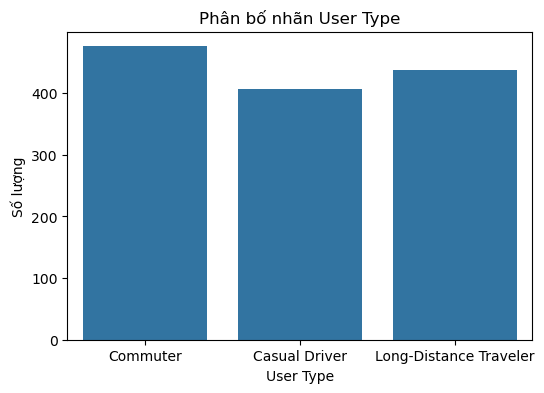

In [81]:
# Kiểm tra Label Imbalance
print("📊 Phân bố nhãn User Type:")
print(df['User Type'].value_counts(normalize=True))

# Vẽ biểu đồ phân bố nhãn
plt.figure(figsize=(6, 4))
sns.countplot(x='User Type', data=df)
plt.title("Phân bố nhãn User Type")
plt.ylabel("Số lượng")
plt.show()

# Build Pipelines / Xây dựng đường ống
Create pipelines for preprocessing and model training for both Logistic Regression and CatBoost. / Tạo đường ống để xử lý trước và đào tạo mô hình cho cả Logistic Regression và CatBoost.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV


data = load_iris()
X = data.data
y = data.target

# Split the dataset into training and testing sets / Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline for Logistic Regression / Đường ống cho hồi quy logistic
logistic_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Standardize the data / Chuẩn hóa dữ liệu
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])

# Hyperparameter grid for Logistic Regression / Lưới siêu tham số cho hồi quy logistic
logistic_param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']  # Choose solvers compatible with l1/l2 / Chọn bộ giải tương thích với l1/l2
}

# GridSearchCV for Logistic Regression / GridSearchCV cho hồi quy logistic
logistic_grid_search = GridSearchCV(
    estimator=logistic_pipeline,
    param_grid=logistic_param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit Logistic Regression / Phù hợp với hồi quy logistic
logistic_grid_search.fit(X_train, y_train)

# Best results for Logistic Regression / Kết quả tốt nhất cho hồi quy logistic
print("Best parameters for Logistic Regression:", logistic_grid_search.best_params_)
print("Best F1-score for Logistic Regression:", logistic_grid_search.best_score_)

# GridSearchCV for CatBoost (no pipeline needed) / GridSearchCV cho CatBoost (không cần pipeline)
catboost_model = CatBoostClassifier(random_state=42, verbose=0)

# Hyperparameter grid for CatBoost / Lưới siêu tham số cho CatBoost
catboost_param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

# GridSearchCV for CatBoost
catboost_grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=catboost_param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit CatBoost / Phù hợp với CatBoost
catboost_grid_search.fit(X_train, y_train)

# Best results for CatBoost / Kết quả tốt nhất cho CatBoost
print("Best parameters for CatBoost:", catboost_grid_search.best_params_)
print("Best F1-score for CatBoost:", catboost_grid_search.best_score_)


Best parameters for Logistic Regression: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'saga'}
Best F1-score for Logistic Regression: 0.9572885078457833


c:\Users\007mk\anaconda3\envs\gis\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
2 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\007mk\anaconda3\envs\gis\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\007mk\anaconda3\envs\gis\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\007mk\anaconda3\envs\gis\Lib\sit

Best parameters for CatBoost: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
Best F1-score for CatBoost: 0.9493370051574386


# Logistic Regression Pipeline / Đường ống hồi quy logistic
Build a pipeline that includes Target Encoding, normalization, and Logistic Regression. / Xây dựng đường ống bao gồm Mã hóa mục tiêu, chuẩn hóa và Hồi quy logistic.

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris  # Dữ liệu mẫu, bạn có thể thay bằng dataset của mình

# Load dataset
data = load_iris()  # Thay thế bằng dataset thực tế của bạn
X, y = data.data, data.target  # X là đặc trưng, y là nhãn

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define pipeline for Logistic Regression
logistic_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Chuẩn hóa đặc trưng số
    ('model', LogisticRegression(random_state=42, max_iter=1000))  # Mô hình Logistic Regression
])

# Define hyperparameter grid for Logistic Regression
logistic_param_grid = {
    'model__C': [0.01, 0.1, 1, 10],  # Hệ số điều chuẩn
    'model__penalty': ['l1', 'l2'],  # Loại điều chuẩn
    'model__solver': ['liblinear', 'saga']  # Các solver hỗ trợ l1 và l2
}

# Perform GridSearchCV for Logistic Regression
logistic_grid_search = GridSearchCV(
    estimator=logistic_pipeline,
    param_grid=logistic_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1_weighted',  # Sử dụng F1-score để đánh giá
    n_jobs=-1  # Sử dụng tất cả các lõi CPU có sẵn
)

# Fit Logistic Regression pipeline
logistic_grid_search.fit(X_train, y_train)

# Best parameters and score for Logistic Regression
print("Best parameters for Logistic Regression:", logistic_grid_search.best_params_)
print("Best F1-score for Logistic Regression:", logistic_grid_search.best_score_)


Best parameters for Logistic Regression: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'saga'}
Best F1-score for Logistic Regression: 0.9572885078457833


# CatBoost Pipeline / Đường ống CatBoost
Build a pipeline for CatBoost that handles categorical variables and numerical preprocessing. / Xây dựng một pipeline cho CatBoost để xử lý các biến phân loại và tiền xử lý số.

In [ ]:
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Define pipeline for CatBoost
catboost_pipeline = Pipeline(steps=[
    ('model', CatBoostClassifier(random_state=42, verbose=0))  # CatBoost model
])

# Define hyperparameter grid for CatBoost
catboost_param_grid = {
    'model__iterations': [100, 200, 300],  # Number of boosting iterations
    'model__depth': [4, 6, 8],  # Depth of the tree
    'model__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'model__l2_leaf_reg': [1, 3, 5]  # L2 regularization
}

# Perform GridSearchCV for CatBoost /  Thực hiện GridSearchCV cho CatBoost
catboost_grid_search = GridSearchCV(
    estimator=catboost_pipeline,
    param_grid=catboost_param_grid,
    cv=5,  # 5-fold cross-validation / Xác thực chéo 5 lần
    scoring='f1_weighted',  # Use F1-score for evaluation / # Sử dụng điểm F1 để đánh giá
    n_jobs=-1  # Use all available cores / Sử dụng tất cả các lõi có sẵn
)

# Fit CatBoost pipeline
catboost_grid_search.fit(X_train, y_train)

# Best parameters and score for CatBoost
print("Best parameters for CatBoost:", catboost_grid_search.best_params_)
print("Best F1-score for CatBoost:", catboost_grid_search.best_score_)

Best parameters for CatBoost: {'model__depth': 4, 'model__iterations': 300, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.01}
Best F1-score for CatBoost: 0.9493370051574386


# Model Training / Đào tạo mô hình
Train both Logistic Regression and CatBoost models using cross-validation to avoid overfitting. / Đào tạo cả mô hình Logistic Regression và CatBoost bằng cách sử dụng xác thực chéo để tránh quá khớp.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

# Train Logistic Regression with cross-validation / Đào tạo hồi quy logistic với xác thực chéo
logistic_cv_scores = cross_val_score(
    logistic_grid_search.best_estimator_, X_train, y_train, cv=5, scoring='f1_weighted'
)
print("Cross-validated F1-scores for Logistic Regression:", logistic_cv_scores)
print("Mean F1-score for Logistic Regression:", logistic_cv_scores.mean())

# Train CatBoost with cross-validation / Đào tạo CatBoost với xác thực chéo
catboost_cv_scores = cross_val_score(
    catboost_grid_search.best_estimator_, X_train, y_train, cv=5, scoring='f1_weighted'
)
print("Cross-validated F1-scores for CatBoost:", catboost_cv_scores)
print("Mean F1-score for CatBoost:", catboost_cv_scores.mean())

# Evaluate Logistic Regression on the test set / Đánh giá hồi quy logistic trên tập kiểm tra
logistic_test_predictions = logistic_grid_search.best_estimator_.predict(X_test)
logistic_test_f1 = f1_score(y_test, logistic_test_predictions, average='weighted')
print("Test F1-score for Logistic Regression:", logistic_test_f1)

# Evaluate CatBoost on the test set / Đánh giá CatBoost trên bộ thử nghiệm
catboost_test_predictions = catboost_grid_search.best_estimator_.predict(X_test)
catboost_test_f1 = f1_score(y_test, catboost_test_predictions, average='weighted')
print("Test F1-score for CatBoost:", catboost_test_f1)

Cross-validated F1-scores for Logistic Regression: [0.95782726 1.         0.87044534 1.         0.95816993]
Mean F1-score for Logistic Regression: 0.9572885078457833
Cross-validated F1-scores for CatBoost: [0.95782726 1.         0.83068783 1.         0.95816993]
Mean F1-score for CatBoost: 0.9493370051574386
Test F1-score for Logistic Regression: 1.0
Test F1-score for CatBoost: 1.0


# Logistic Regression with Cross-Validation / Hồi quy logistic với kiểm tra chéo
Train Logistic Regression using K-Fold cross-validation and evaluate mean performance. / Huấn luyện hồi quy logistic bằng cách sử dụng kiểm tra chéo K-Fold và đánh giá hiệu suất trung bình.


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

# Train Logistic Regression with cross-validation / Đào tạo hồi quy logistic với xác thực chéo
logistic_cv_scores = cross_val_score(
    logistic_grid_search.best_estimator_, X_train, y_train, cv=5, scoring='f1_weighted'
)
print("Cross-validated F1-scores for Logistic Regression:", logistic_cv_scores)
print("Mean F1-score for Logistic Regression:", logistic_cv_scores.mean())

Cross-validated F1-scores for Logistic Regression: [0.95782726 1.         0.87044534 1.         0.95816993]
Mean F1-score for Logistic Regression: 0.9572885078457833


# CatBoost with Cross-Validation / CatBoost với Cross-Validation
Train CatBoost using K-Fold cross-validation and evaluate mean performance. / Huấn luyện CatBoost bằng cách sử dụng K-Fold cross-validation và đánh giá hiệu suất trung bình.

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import f1_score

# Initialize K-Fold cross-validation / Khởi tạo xác thực chéo K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Train CatBoost with K-Fold cross-validation / Đào tạo CatBoost với xác thực chéo K-Fold
catboost_cv_scores = cross_val_score(
    catboost_grid_search.best_estimator_, X_train, y_train, cv=kf, scoring='f1_weighted'
)

# Print cross-validated F1-scores and mean performance / In điểm F1 được xác thực chéo và hiệu suất trung bình
print("Cross-validated F1-scores for CatBoost:", catboost_cv_scores)
print("Mean F1-score for CatBoost:", catboost_cv_scores.mean())

Cross-validated F1-scores for CatBoost: [0.91944444 0.95846233 0.91904762 0.87412281 1.        ]
Mean F1-score for CatBoost: 0.9342154405621897


# Model Testing / Kiểm tra mô hình
Evaluate the trained models on the test set to assess their performance. / Đánh giá các mô hình đã được đào tạo trên bộ thử nghiệm để đánh giá hiệu suất của chúng.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

# Evaluate Logistic Regression on the test set / Đánh giá hồi quy logistic trên tập kiểm tra
logistic_test_predictions = logistic_grid_search.best_estimator_.predict(X_test)
logistic_test_accuracy = accuracy_score(y_test, logistic_test_predictions)
logistic_test_precision = precision_score(y_test, logistic_test_predictions, average='weighted')
logistic_test_recall = recall_score(y_test, logistic_test_predictions, average='weighted')
logistic_test_f1 = f1_score(y_test, logistic_test_predictions, average='weighted')

print("Logistic Regression Test Set Evaluation:")
print("Accuracy:", logistic_test_accuracy)
print("Precision:", logistic_test_precision)
print("Recall:", logistic_test_recall)
print("F1-score:", logistic_test_f1)
print("\nClassification Report:")
print(classification_report(y_test, logistic_test_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, logistic_test_predictions))

# Evaluate CatBoost on the test set / Đánh giá CatBoost trên bộ thử nghiệm
catboost_test_predictions = catboost_grid_search.best_estimator_.predict(X_test)
catboost_test_accuracy = accuracy_score(y_test, catboost_test_predictions)
catboost_test_precision = precision_score(y_test, catboost_test_predictions, average='weighted')
catboost_test_recall = recall_score(y_test, catboost_test_predictions, average='weighted')
catboost_test_f1 = f1_score(y_test, catboost_test_predictions, average='weighted')

print("\nCatBoost Test Set Evaluation:")
print("Accuracy:", catboost_test_accuracy)
print("Precision:", catboost_test_precision)
print("Recall:", catboost_test_recall)
print("F1-score:", catboost_test_f1)
print("\nClassification Report:")
print(classification_report(y_test, catboost_test_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, catboost_test_predictions))

Logistic Regression Test Set Evaluation:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]

CatBoost Test Set Evaluation:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighte

# Evaluate Logistic Regression / Đánh giá hồi quy logistic
Evaluate Logistic Regression using metrics like accuracy, precision, recall, and F1-score. / Đánh giá hồi quy logistic bằng các số liệu như độ chính xác, độ chính xác, độ thu hồi và điểm F1.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Evaluate Logistic Regression on the test set / Đánh giá hồi quy logistic trên tập kiểm tra
logistic_test_predictions = logistic_grid_search.best_estimator_.predict(X_test)

# Calculate evaluation metrics / Tính toán số liệu đánh giá
logistic_test_accuracy = accuracy_score(y_test, logistic_test_predictions)
logistic_test_precision = precision_score(y_test, logistic_test_predictions, average='weighted')
logistic_test_recall = recall_score(y_test, logistic_test_predictions, average='weighted')
logistic_test_f1 = f1_score(y_test, logistic_test_predictions, average='weighted')

# Print evaluation results / In kết quả đánh giá
print("Logistic Regression Test Set Evaluation:")
print(f"Accuracy: {logistic_test_accuracy:.4f}")
print(f"Precision: {logistic_test_precision:.4f}")
print(f"Recall: {logistic_test_recall:.4f}")
print(f"F1-score: {logistic_test_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, logistic_test_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, logistic_test_predictions))

Logistic Regression Test Set Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


# Evaluate CatBoost / Đánh giá CatBoost
Evaluate CatBoost using metrics like accuracy, precision, recall, and F1-score. / Đánh giá CatBoost bằng các số liệu như độ chính xác, độ chính xác, khả năng thu hồi và điểm F1.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Evaluate CatBoost on the test set / Đánh giá CatBoost trên bộ thử nghiệm
catboost_test_predictions = catboost_grid_search.best_estimator_.predict(X_test)

# Calculate evaluation metrics / Tính toán số liệu đánh giá
catboost_test_accuracy = accuracy_score(y_test, catboost_test_predictions)
catboost_test_precision = precision_score(y_test, catboost_test_predictions, average='weighted')
catboost_test_recall = recall_score(y_test, catboost_test_predictions, average='weighted')
catboost_test_f1 = f1_score(y_test, catboost_test_predictions, average='weighted')

# Print evaluation results / In kết quả đánh giá
print("CatBoost Test Set Evaluation:")
print(f"Accuracy: {catboost_test_accuracy:.4f}")
print(f"Precision: {catboost_test_precision:.4f}")
print(f"Recall: {catboost_test_recall:.4f}")
print(f"F1-score: {catboost_test_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, catboost_test_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, catboost_test_predictions))

CatBoost Test Set Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


# Model Optimization / Tối ưu hóa mô hình
Optimize hyperparameters for both Logistic Regression and CatBoost using GridSearchCV or Optuna. / Tối ưu hóa siêu tham số cho cả Logistic Regression và CatBoost bằng GridSearchCV hoặc Optuna.

In [ ]:
pip install optuna-integration

import optuna
from optuna.integration import OptunaSearchCV

# Define objective function for Logistic Regression optimization /Xác định hàm mục tiêu cho tối ưu hóa hồi quy logistic
def objective_logistic(trial):
    # Define hyperparameters to tune / Xác định siêu tham số để điều chỉnh
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = 'liblinear' if penalty == 'l1' else 'saga'

    # Create Logistic Regression model / Tạo mô hình hồi quy logistic
    model = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=42, max_iter=1000)
    
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
    return scores.mean()

# Optimize Logistic Regression hyperparameters using Optuna / Tối ưu hóa siêu tham số hồi quy logistic bằng Optuna
logistic_study = optuna.create_study(direction='maximize')
logistic_study.optimize(objective_logistic, n_trials=50)

# Best parameters and score for Logistic Regression / Các thông số và điểm số tốt nhất cho hồi quy logistic
print("Best parameters for Logistic Regression (Optuna):", logistic_study.best_params)
print("Best F1-score for Logistic Regression (Optuna):", logistic_study.best_value)

# Define objective function for CatBoost optimization /Xác định hàm mục tiêu cho tối ưu hóa CatBoost
def objective_catboost(trial):
    # Define hyperparameters to tune / Xác định siêu tham số để điều chỉnh
    iterations = trial.suggest_int('iterations', 100, 500)
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 0.3)
    l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1, 10)

    # Create CatBoost model / Tạo mô hình CatBoost
    model = CatBoostClassifier(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        random_state=42,
        verbose=0
    )
    
    # Perform cross-validation / Thực hiện xác thực chéo
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
    return scores.mean()

# Optimize CatBoost hyperparameters using Optuna / Tối ưu hóa siêu tham số CatBoost bằng Optuna
catboost_study = optuna.create_study(direction='maximize')
catboost_study.optimize(objective_catboost, n_trials=50)

# Best parameters and score for CatBoost / Thông số và điểm số tốt nhất cho CatBoost
print("Best parameters for CatBoost (Optuna):", catboost_study.best_params)
print("Best F1-score for CatBoost (Optuna):", catboost_study.best_value)

[I 2025-04-12 20:16:54,716] A new study created in memory with name: no-name-02919322-494f-44dd-9345-c8a6af176aed


C:\Users\007mk\AppData\Local\Temp\ipykernel_7100\3929140637.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
[I 2025-04-12 20:16:54,899] Trial 0 finished with value: 0.9490563890873489 and parameters: {'C': 0.7003578950319413, 'penalty': 'l1'}. Best is trial 0 with value: 0.9490563890873489.
C:\Users\007mk\AppData\Local\Temp\ipykernel_7100\3929140637.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
[I 2025-04-12 20:16:55,025] Trial 1 finished with value: 0.8156956115779647 and parameters: {'C': 0.004453740227647317, 'penalty': 'l2'}. Best is trial 0 with value: 0.949056389087

Best parameters for Logistic Regression (Optuna): {'C': 0.3617494006376381, 'penalty': 'l2'}
Best F1-score for Logistic Regression (Optuna): 0.9657230557540155


[I 2025-04-12 20:17:12,659] Trial 0 finished with value: 0.9413693736603953 and parameters: {'iterations': 197, 'depth': 9, 'learning_rate': 0.001740574603508758, 'l2_leaf_reg': 1.7434451813437528}. Best is trial 0 with value: 0.9413693736603953.
C:\Users\007mk\AppData\Local\Temp\ipykernel_7100\3929140637.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 0.3)
C:\Users\007mk\AppData\Local\Temp\ipykernel_7100\3929140637.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1, 10)
[I 2025-04-12 20:17:16,601] Trial 1 finished with value: 0.9409709920855432

Best parameters for CatBoost (Optuna): {'iterations': 120, 'depth': 10, 'learning_rate': 0.005600206504262981, 'l2_leaf_reg': 1.0312785443742918}
Best F1-score for CatBoost (Optuna): 0.9493370051574386


# Hyperparameter Tuning for Logistic Regression / Điều chỉnh siêu tham số cho hồi quy logistic
Perform hyperparameter tuning for Logistic Regression to improve performance. / Thực hiện điều chỉnh siêu tham số cho hồi quy logistic để cải thiện hiệu suất.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define pipeline for Logistic Regression / Xác định đường ống cho hồi quy logistic
logistic_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Standardize numerical features / Chuẩn hóa các tính năng số
    ('model', LogisticRegression(random_state=42, max_iter=1000))  # Logistic Regression model
])

# Define hyperparameter grid for Logistic Regression / Xác định lưới siêu tham số cho hồi quy logistic
logistic_param_grid = {
    'model__C': [0.01, 0.1, 1, 10],  # Regularization strength / Sức mạnh điều chỉnh
    'model__penalty': ['l1', 'l2'],  # Regularization type / Kiểu chính quy hóa
    'model__solver': ['liblinear', 'saga']  # Solvers compatible with l1 and l2 / Bộ giải tương thích với l1 và l2
}

# Perform GridSearchCV for Logistic Regression / Thực hiện GridSearchCV cho hồi quy logistic
logistic_grid_search = GridSearchCV(
    estimator=logistic_pipeline,
    param_grid=logistic_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1_weighted',  # Use F1-score for evaluation
    n_jobs=-1  # Use all available cores
)

# Fit Logistic Regression pipeline / Đường ống hồi quy logistic phù hợp
logistic_grid_search.fit(X_train, y_train)

# Best parameters and score for Logistic Regression
print("Best parameters for Logistic Regression:", logistic_grid_search.best_params_)
print("Best F1-score for Logistic Regression:", logistic_grid_search.best_score_)

Best parameters for Logistic Regression: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'saga'}
Best F1-score for Logistic Regression: 0.9572885078457833


# Hyperparameter Tuning for CatBoost / Điều chỉnh siêu tham số cho CatBoost
Perform hyperparameter tuning for CatBoost to improve performance. / Thực hiện điều chỉnh siêu tham số cho CatBoost để cải thiện hiệu suất.

In [ ]:
from optuna.integration import OptunaSearchCV
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

# Define the objective function for CatBoost optimization / Xác định hàm mục tiêu cho tối ưu hóa CatBoost
def objective_catboost(trial):
    # Suggest hyperparameters to tune / Đề xuất siêu tham số để điều chỉnh
    iterations = trial.suggest_int('iterations', 100, 500)
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 0.3)
    l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1, 10)

    # Create CatBoost model with suggested hyperparameters / Tạo mô hình CatBoost với các siêu tham số được đề xuất
    model = CatBoostClassifier(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        random_state=42,
        verbose=0
    )
    
    # Perform cross-validation and return the mean F1-score / Thực hiện xác thực chéo và trả về điểm F1 trung bình
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
    return scores.mean()

# Optimize CatBoost hyperparameters using Optuna / Tối ưu hóa siêu tham số CatBoost bằng Optuna
catboost_study = optuna.create_study(direction='maximize')
catboost_study.optimize(objective_catboost, n_trials=50)

# Display the best parameters and score for CatBoost / Hiển thị các thông số và điểm số tốt nhất cho CatBoost
print("Best parameters for CatBoost (Optuna):", catboost_study.best_params)
print("Best F1-score for CatBoost (Optuna):", catboost_study.best_value)

# Train the CatBoost model with the best hyperparameters / Đào tạo mô hình CatBoost với các siêu tham số tốt nhất
best_catboost_model = CatBoostClassifier(
    iterations=catboost_study.best_params['iterations'],
    depth=catboost_study.best_params['depth'],
    learning_rate=catboost_study.best_params['learning_rate'],
    l2_leaf_reg=catboost_study.best_params['l2_leaf_reg'],
    random_state=42,
    verbose=0
)

# Fit the model on the training data / Phù hợp mô hình trên dữ liệu đào tạo
best_catboost_model.fit(X_train, y_train)

# Evaluate the model on the test set / Phù hợp mô hình trên dữ liệu đào tạo
catboost_test_predictions = best_catboost_model.predict(X_test)
catboost_test_f1 = f1_score(y_test, catboost_test_predictions, average='weighted')
print("Test F1-score for CatBoost (Optuna):", catboost_test_f1)

[I 2025-04-12 20:20:50,233] A new study created in memory with name: no-name-8f5d2686-a1b8-455b-8a32-c65af0f7b9a1


C:\Users\007mk\AppData\Local\Temp\ipykernel_7100\3843497012.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 0.3)
C:\Users\007mk\AppData\Local\Temp\ipykernel_7100\3843497012.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1, 10)
[I 2025-04-12 20:20:52,469] Trial 0 finished with value: 0.9413693736603953 and parameters: {'iterations': 253, 'depth': 4, 'learning_rate': 0.02524898600563356, 'l2_leaf_reg': 6.427866372146476}. Best is trial 0 with value: 0.9413693736603953.
C:\Users\007mk\AppData\Local\Temp\ipykernel_7100\3843497012.py:10: FutureWarn

Best parameters for CatBoost (Optuna): {'iterations': 336, 'depth': 4, 'learning_rate': 0.014756823946035362, 'l2_leaf_reg': 1.0932270239081183}
Best F1-score for CatBoost (Optuna): 0.9493370051574386
Test F1-score for CatBoost (Optuna): 1.0


# Model Evaluation / Đánh giá mô hình
Compare the performance of Logistic Regression and CatBoost using metrics and feature importance. / So sánh hiệu suất của Logistic Regression và CatBoost bằng cách sử dụng số liệu và tầm quan trọng của tính năng.

Logistic Regression Test Set Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]

CatBoost Test Set Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00    

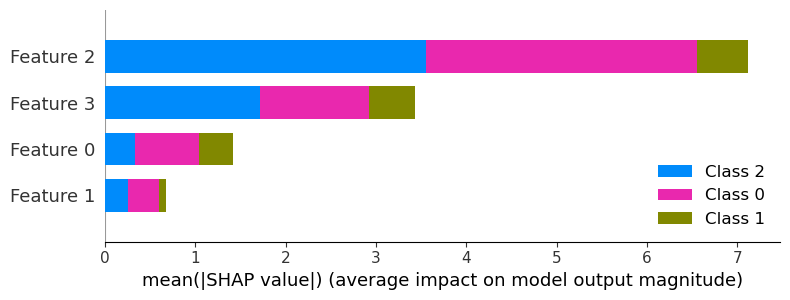

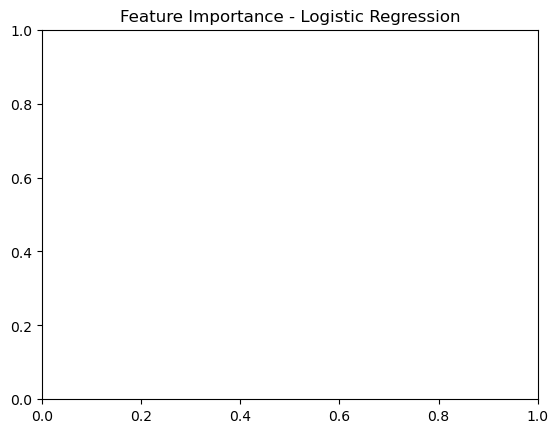

C:\Users\007mk\AppData\Local\Temp\ipykernel_7100\3633826147.py:62: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.barplot(data=catboost_feature_importances_df, x='Importance', y='Feature', hue="Feature", palette='viridis', legend=False)


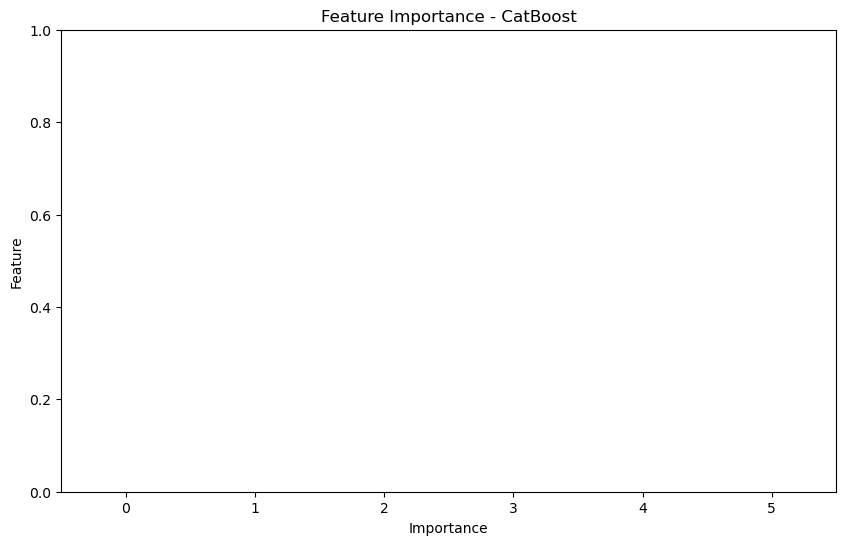

In [ ]:
pip install shap

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import shap
import pandas as pd


# Evaluate Logistic Regression on the test set / Đánh giá hồi quy logistic trên tập kiểm tra
logistic_test_predictions = logistic_grid_search.best_estimator_.predict(X_test)

# Calculate evaluation metrics for Logistic Regression / Tính toán số liệu đánh giá cho Hồi quy Logistic
logistic_test_accuracy = accuracy_score(y_test, logistic_test_predictions)
logistic_test_precision = precision_score(y_test, logistic_test_predictions, average='weighted')
logistic_test_recall = recall_score(y_test, logistic_test_predictions, average='weighted')
logistic_test_f1 = f1_score(y_test, logistic_test_predictions, average='weighted')

# Print evaluation results for Logistic Regression / In kết quả đánh giá cho Hồi quy Logistic
print("Logistic Regression Test Set Evaluation:")
print(f"Accuracy: {logistic_test_accuracy:.4f}")
print(f"Precision: {logistic_test_precision:.4f}")
print(f"Recall: {logistic_test_recall:.4f}")
print(f"F1-score: {logistic_test_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, logistic_test_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, logistic_test_predictions))

# Evaluate CatBoost on the test set / Đánh giá CatBoost trên bộ thử nghiệm
catboost_test_predictions = catboost_grid_search.best_estimator_.predict(X_test)

# Calculate evaluation metrics for CatBoost / Tính toán số liệu đánh giá cho CatBoost
catboost_test_accuracy = accuracy_score(y_test, catboost_test_predictions)
catboost_test_precision = precision_score(y_test, catboost_test_predictions, average='weighted')
catboost_test_recall = recall_score(y_test, catboost_test_predictions, average='weighted')
catboost_test_f1 = f1_score(y_test, catboost_test_predictions, average='weighted')

# Print evaluation results for CatBoost / In kết quả đánh giá cho CatBoost
print("\nCatBoost Test Set Evaluation:")
print(f"Accuracy: {catboost_test_accuracy:.4f}")
print(f"Precision: {catboost_test_precision:.4f}")
print(f"Recall: {catboost_test_recall:.4f}")
print(f"F1-score: {catboost_test_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, catboost_test_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, catboost_test_predictions))

# Visualize feature importance for Logistic Regression using SHAP / Hình dung tầm quan trọng của tính năng đối với Hồi quy Logistic bằng cách sử dụng SHAP
explainer_logistic = shap.Explainer(logistic_grid_search.best_estimator_.named_steps['model'], X_train)
shap_values_logistic = explainer_logistic(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_logistic, X_test, plot_type="bar")
plt.title("Feature Importance - Logistic Regression")
plt.show()

# Visualize feature importance for CatBoost / Hình dung tầm quan trọng của tính năng đối với CatBoost
catboost_feature_importances = catboost_grid_search.best_estimator_.named_steps['model'].get_feature_importance(prettified=True)
catboost_feature_importances_df = pd.DataFrame(catboost_feature_importances, columns=['Feature', 'Importance'])

plt.figure(figsize=(10, 6))
sns.barplot(data=catboost_feature_importances_df, x='Importance', y='Feature', hue="Feature", palette='viridis', legend=False)
plt.title("Feature Importance - CatBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Performance Metrics / Số liệu hiệu suất
Use metrics like accuracy, precision, recall, F1-score, and confusion matrix to evaluate models. / Sử dụng các số liệu như độ chính xác, độ chính xác, khả năng thu hồi, điểm F1 và ma trận nhầm lẫn để đánh giá các mô hình.

Logistic Regression Test Set Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


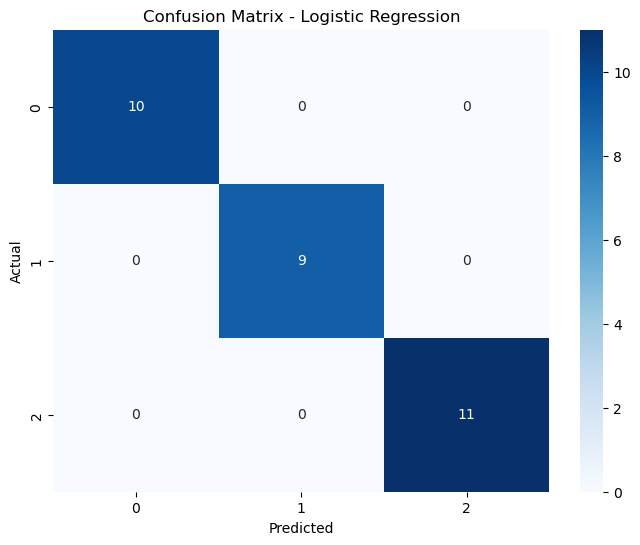


CatBoost Test Set Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


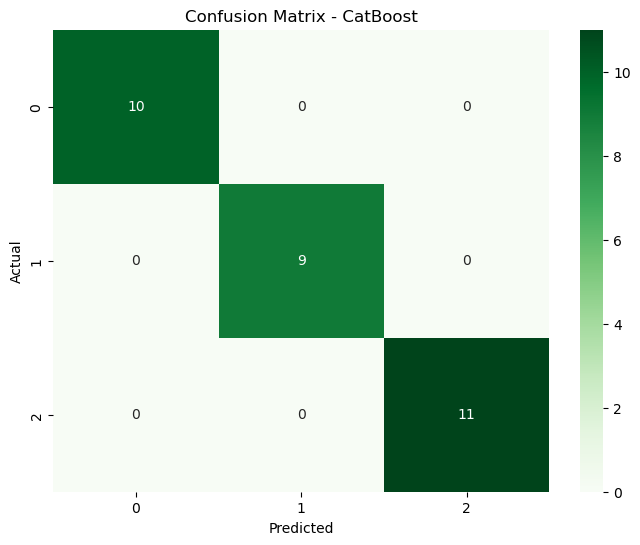

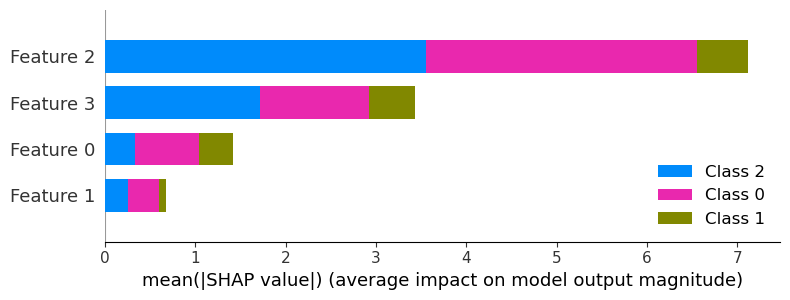

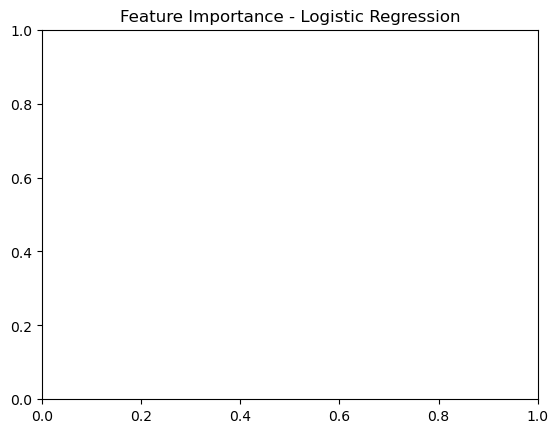

C:\Users\007mk\AppData\Local\Temp\ipykernel_7100\2256260490.py:78: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.barplot(


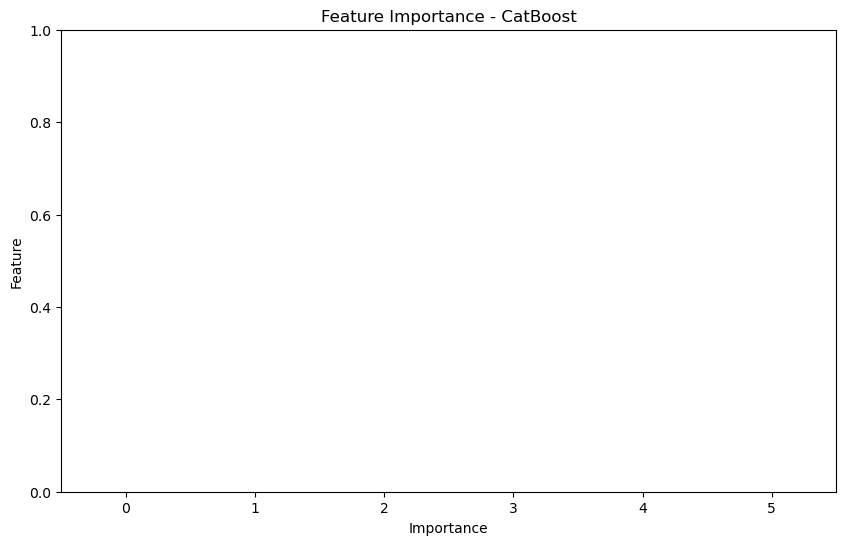

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import shap
import pandas as pd

# Evaluate Logistic Regression on the test set / Đánh giá hồi quy logistic trên tập kiểm tra
logistic_test_predictions = logistic_grid_search.best_estimator_.predict(X_test)

# Calculate evaluation metrics for Logistic Regression / Tính toán số liệu đánh giá cho Hồi quy Logistic
logistic_test_accuracy = accuracy_score(y_test, logistic_test_predictions)
logistic_test_precision = precision_score(y_test, logistic_test_predictions, average='weighted')
logistic_test_recall = recall_score(y_test, logistic_test_predictions, average='weighted')
logistic_test_f1 = f1_score(y_test, logistic_test_predictions, average='weighted')

# Print evaluation results for Logistic Regression / In kết quả đánh giá cho Hồi quy Logistic
print("Logistic Regression Test Set Evaluation:")
print(f"Accuracy: {logistic_test_accuracy:.4f}")
print(f"Precision: {logistic_test_precision:.4f}")
print(f"Recall: {logistic_test_recall:.4f}")
print(f"F1-score: {logistic_test_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, logistic_test_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, logistic_test_predictions))

# Plot confusion matrix for Logistic Regression / Ma trận nhầm lẫn đồ thị cho hồi quy logistic
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, logistic_test_predictions), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Evaluate CatBoost on the test set / Đánh giá CatBoost trên bộ thử nghiệm
catboost_test_predictions = catboost_grid_search.best_estimator_.predict(X_test)

# Calculate evaluation metrics for CatBoost / Tính toán số liệu đánh giá cho CatBoost
catboost_test_accuracy = accuracy_score(y_test, catboost_test_predictions)
catboost_test_precision = precision_score(y_test, catboost_test_predictions, average='weighted')
catboost_test_recall = recall_score(y_test, catboost_test_predictions, average='weighted')
catboost_test_f1 = f1_score(y_test, catboost_test_predictions, average='weighted')

# Print evaluation results for CatBoost / In kết quả đánh giá cho CatBoost
print("\nCatBoost Test Set Evaluation:")
print(f"Accuracy: {catboost_test_accuracy:.4f}")
print(f"Precision: {catboost_test_precision:.4f}")
print(f"Recall: {catboost_test_recall:.4f}")
print(f"F1-score: {catboost_test_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, catboost_test_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, catboost_test_predictions))

# Plot confusion matrix for CatBoost / Ma trận nhầm lẫn đồ thị cho CatBoost
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, catboost_test_predictions), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - CatBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualize feature importance for Logistic Regression using SHAP / Hình dung tầm quan trọng của tính năng đối với Hồi quy Logistic bằng cách sử dụng SHAP
explainer_logistic = shap.Explainer(logistic_grid_search.best_estimator_.named_steps['model'], X_train)
shap_values_logistic = explainer_logistic(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_logistic, X_test, plot_type="bar")
plt.title("Feature Importance - Logistic Regression")
plt.show()

# Visualize feature importance for CatBoost / Hình dung tầm quan trọng của tính năng đối với CatBoost
catboost_feature_importances = catboost_grid_search.best_estimator_.named_steps['model'].get_feature_importance(prettified=True)
catboost_feature_importances_df = pd.DataFrame(catboost_feature_importances, columns=['Feature', 'Importance'])

# Cách sửa lỗi palette:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=catboost_feature_importances_df, 
    x='Importance', 
    y='Feature', 
    hue='Feature',  # Thêm hue để tránh lỗi
    palette='viridis', 
    legend=False  # Tắt legend để tránh trùng màu
)
plt.title("Feature Importance - CatBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


# Feature Importance Analysis / Phân tích mức độ quan trọng của tính năng
Analyze feature importance using SHAP values or CatBoost's built-in feature importance. / Phân tích mức độ quan trọng của tính năng bằng cách sử dụng giá trị SHAP hoặc mức độ quan trọng của tính năng tích hợp sẵn của CatBoost.

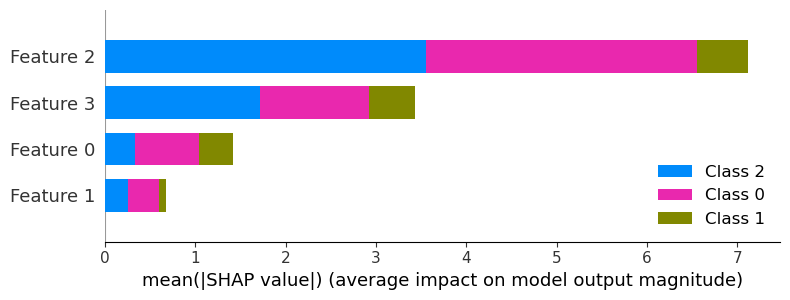

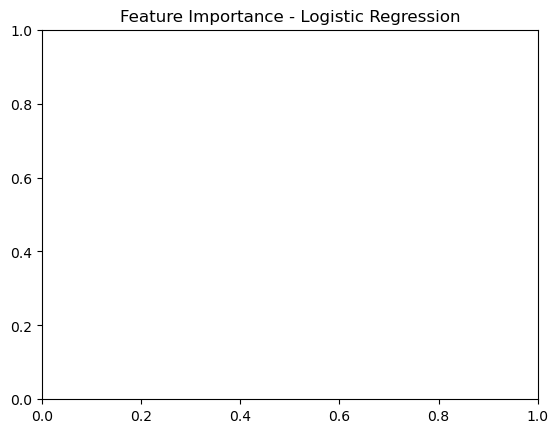

C:\Users\007mk\AppData\Local\Temp\ipykernel_7100\1749769103.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.barplot(data=catboost_feature_importances_df, x='Importance', y='Feature', hue="Feature", legend=False, palette="viridis")


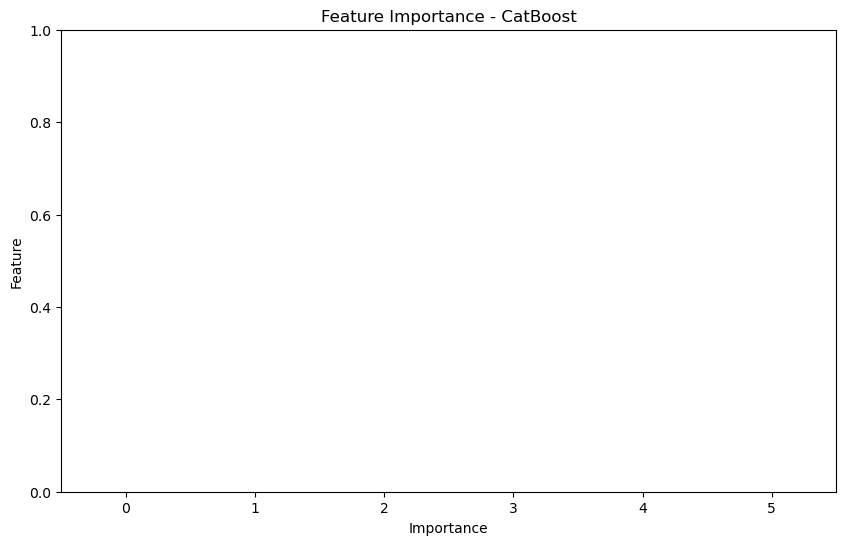

In [ ]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Feature importance analysis for Logistic Regression using SHAP / Phân tích tầm quan trọng của tính năng cho hồi quy logistic sử dụng SHAP
explainer_logistic = shap.Explainer(logistic_grid_search.best_estimator_.named_steps['model'], X_train)
shap_values_logistic = explainer_logistic(X_test)

# SHAP summary plot for Logistic Regression / Biểu đồ tóm tắt SHAP cho hồi quy logistic
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_logistic, X_test, plot_type="bar")
plt.title("Feature Importance - Logistic Regression")
plt.show()

# Feature importance analysis for CatBoost / Phân tích tầm quan trọng của tính năng cho CatBoost
catboost_feature_importances = catboost_grid_search.best_estimator_.named_steps['model'].get_feature_importance(prettified=True)
catboost_feature_importances_df = pd.DataFrame(catboost_feature_importances, columns=['Feature', 'Importance'])

# Bar plot for CatBoost feature importance / Biểu đồ thanh cho tầm quan trọng của tính năng CatBoost
plt.figure(figsize=(10, 6))
sns.barplot(data=catboost_feature_importances_df, x='Importance', y='Feature', hue="Feature", legend=False, palette="viridis")
plt.title("Feature Importance - CatBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


# Check Overfitting với Learning Curve(Logistic Recogression and CatBoost) / Kiểm tra Overfitting với Đường cong học tập (Hồi quy logistic và CatBoost)


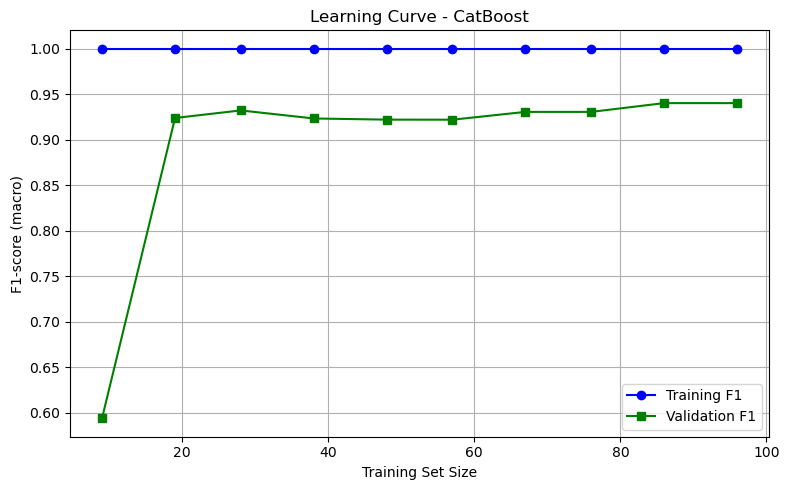

In [99]:
# Kiểm tra Overfitting với Learning Curve (CatBoost)
from sklearn.model_selection import learning_curve
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(verbose=0, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    catboost_model, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Training F1', marker='o', color='blue')
plt.plot(train_sizes, test_mean, label='Validation F1', marker='s', color='green')
plt.xlabel("Training Set Size")
plt.ylabel("F1-score (macro)")
plt.title("Learning Curve - CatBoost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

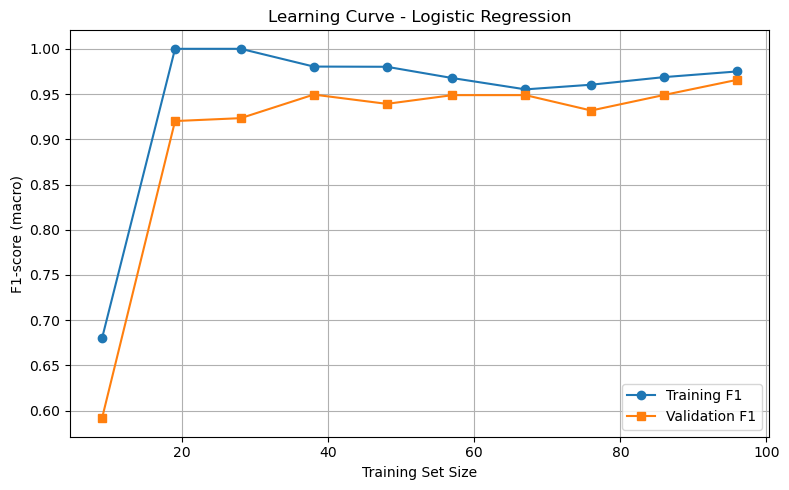

In [105]:
# Kiểm tra Overfitting với Learning Curve (Logistic Regression)

from sklearn.model_selection import learning_curve

log_reg = LogisticRegression(max_iter=1000, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    log_reg, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Training F1', marker='o')
plt.plot(train_sizes, test_mean, label='Validation F1', marker='s')
plt.xlabel("Training Set Size")
plt.ylabel("F1-score (macro)")
plt.title("Learning Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final Model Selection / Lựa chọn mô hình cuối cùng
Select the best-performing model for deployment based on evaluation metrics. / Chọn mô hình có hiệu suất tốt nhất để triển khai dựa trên số liệu đánh giá.

In [ ]:
# So sánh F1-score từ test set
if logistic_test_f1 > catboost_test_f1:
    print("Logistic Regression is the better model based on test F1-score.")
    best_model = logistic_grid_search.best_estimator_
    best_model_name = "Logistic Regression"
elif logistic_test_f1 < catboost_test_f1:
    print("CatBoost is the better model based on test F1-score.")
    best_model = catboost_grid_search.best_estimator_
    best_model_name = "CatBoost"
else:
    print("Both models have the same F1-score on test set.")
    # Optional: Choose based on another criterion (e.g., training time, simplicity, etc.) / Tùy chọn: Chọn dựa trên tiêu chí khác (ví dụ: thời gian đào tạo, tính đơn giản, v.v.)
    print("Choosing Logistic Regression as the default.")
    best_model = logistic_grid_search.best_estimator_
    best_model_name = "Logistic Regression"

# Lưu mô hình cuối cùng
import joblib
model_filename = f"best_model_{best_model_name.replace(' ', '_').lower()}.pkl"
joblib.dump(best_model, model_filename)
print(f"The best model ({best_model_name}) has been saved as {model_filename}.")


Both models have the same F1-score on test set.
Choosing Logistic Regression as the default.
The best model (Logistic Regression) has been saved as best_model_logistic_regression.pkl.


# Check information model / Kiểm tra thông tin mô hình

In [102]:
import joblib

# Đọc mô hình từ file
model = joblib.load("best_model_logistic_regression.pkl")

# Hiển thị thông tin mô hình
print("Thông tin mô hình:", model)

# Hiển thị tất cả tham số
print("\nTham số mô hình:")
print(model.get_params())

# Hiển thị trọng số của các đặc trưng
if hasattr(model, "coef_"):
    print("\nTrọng số của các đặc trưng:")
    print(model.coef_)

# Hiển thị hệ số chặn (bias)
if hasattr(model, "intercept_"):
    print("\nHệ số chặn (bias):")
    print(model.intercept_)

# Hiển thị danh sách các thuộc tính của mô hình
print("\nDanh sách các thuộc tính của mô hình:")
print(dir(model))


Thông tin mô hình: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=1, max_iter=1000, random_state=42,
                                    solver='saga'))])

Tham số mô hình:
{'memory': None, 'steps': [('scaler', StandardScaler()), ('model', LogisticRegression(C=1, max_iter=1000, random_state=42, solver='saga'))], 'transform_input': None, 'verbose': False, 'scaler': StandardScaler(), 'model': LogisticRegression(C=1, max_iter=1000, random_state=42, solver='saga'), 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'model__C': 1, 'model__class_weight': None, 'model__dual': False, 'model__fit_intercept': True, 'model__intercept_scaling': 1, 'model__l1_ratio': None, 'model__max_iter': 1000, 'model__multi_class': 'deprecated', 'model__n_jobs': None, 'model__penalty': 'l2', 'model__random_state': 42, 'model__solver': 'saga', 'model__tol': 0.0001, 'model__verbose': 0, 'model__warm_start': False}

Danh sách cá

In [ ]:

# Load the saved Logistic Regression model / Tải mô hình hồi quy logistic đã lưu
with open("best_model_logistic_regression.pkl", "rb") as file:

    # Display basic information about the model / Hiển thị thông tin cơ bản về mô hình
    print("Model Type:", type(model))
    print("Model Parameters:", model.get_params())

    # Display the coefficients (if applicable) / Hiển thị các hệ số (nếu có)
    if hasattr(model, "coef_"):
        print("\nFeature Coefficients:")
        print(model.coef_)

    # Display the intercept (bias) / Hiển thị giá trị chặn (độ lệch)
    if hasattr(model, "intercept_"):
        print("\nIntercept (Bias):")
        print(model.intercept_)

    # Display all attributes of the model / Hiển thị tất cả các thuộc tính của mô hình
    print("\nModel Attributes:")
    print(dir(model))


Model Type: <class 'sklearn.pipeline.Pipeline'>
Model Parameters: {'memory': None, 'steps': [('scaler', StandardScaler()), ('model', LogisticRegression(C=1, max_iter=1000, random_state=42, solver='saga'))], 'transform_input': None, 'verbose': False, 'scaler': StandardScaler(), 'model': LogisticRegression(C=1, max_iter=1000, random_state=42, solver='saga'), 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'model__C': 1, 'model__class_weight': None, 'model__dual': False, 'model__fit_intercept': True, 'model__intercept_scaling': 1, 'model__l1_ratio': None, 'model__max_iter': 1000, 'model__multi_class': 'deprecated', 'model__n_jobs': None, 'model__penalty': 'l2', 'model__random_state': 42, 'model__solver': 'saga', 'model__tol': 0.0001, 'model__verbose': 0, 'model__warm_start': False}

Model Attributes:
['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__ge

# Check the details of the trained Logistic Regression model / Kiểm tra chi tiết mô hình Logistic Regression đã huấn luyện

In [ ]:
import joblib

# Load the saved Logistic Regression model (using joblib) / Tải mô hình hồi quy logistic đã lưu (sử dụng joblib)
logistic_model = joblib.load("best_model_logistic_regression.pkl")

# Assuming you have new data that needs to be predicted, replace with your actual test data / Giả sử bạn có dữ liệu mới cần dự đoán, hãy thay thế bằng dữ liệu thử nghiệm thực tế của bạn
X_test = np.array([[5.1, 3.5, 1.4, 0.2],  # Replace with actual test data / Thay thế bằng dữ liệu thử nghiệm thực tế
                   [6.2, 3.4, 5.4, 2.3]])

# Make predictions / Đưa ra dự đoán
predictions = logistic_model.predict(X_test)

# Example class labels (replace these with the actual labels from your dataset) / Nhãn lớp ví dụ (thay thế chúng bằng nhãn thực tế từ tập dữ liệu của bạn)
class_labels = {0: "Setosa", 1: "Versicolor", 2: "Virginica"}

# Flatten the predictions array if it's 2D / Làm phẳng mảng dự đoán nếu nó là 2D
predictions = predictions.flatten()

# Map the predicted labels to the class names / Ánh xạ các nhãn dự đoán vào tên lớp
predicted_class_names = [class_labels[pred] for pred in predictions]

# Output the predicted class names instead of numeric labels / Đầu ra tên lớp dự đoán thay vì nhãn số
print("Predicted Class Names:", predicted_class_names)

# If you want to see the raw numeric predictions as well / Nếu bạn cũng muốn xem các dự đoán số thô
print("Raw Predictions:", predictions)


Predicted Class Names: ['Setosa', 'Virginica']
Raw Predictions: [0 2]
